### Construct Kinematic Chain using `networkx` package

In [13]:
import copy,cv2,glob,os
import numpy as np
import mediapy as media
import networkx as nx
import matplotlib.pyplot as plt
from util import r2rpy,rpy2r,rodrigues,create_folder_if_not_exists, rpy2R
from mujoco_parser import MuJoCoParserClass
from kin_chain import KinematicChainClass
# from networkx.algorithms.traversal.depth_first_search import dfs_edges
np.set_printoptions(precision=2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("networkx version:[%s]"%(nx.__version__))

networkx version:[3.1]


### Load Bvh & initialize kinematic chain

Reading BVH file...
done
Building skeleton...
done
Analyzing frames...
done


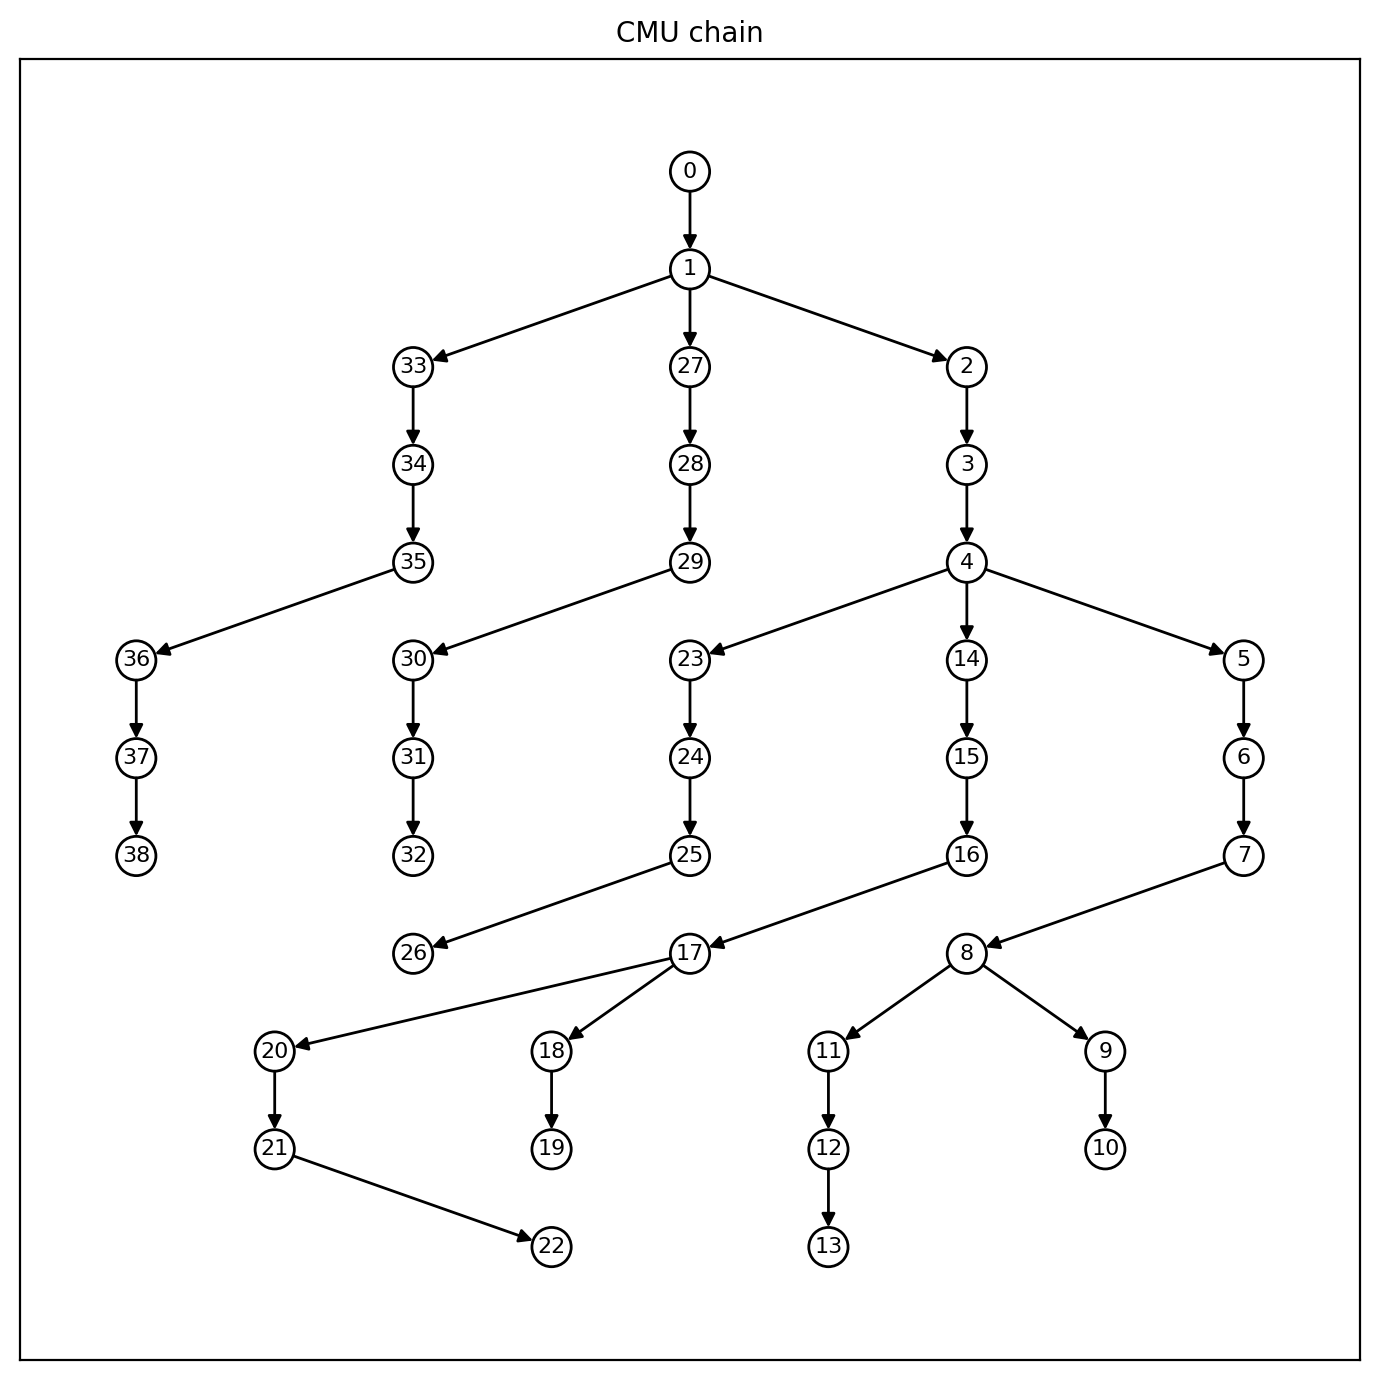

[0/39] joint name:[World] p:[0 0 0] rpy_deg:[0. 0. 0.]
[1/39] joint name:[Hips] p:[0.  0.  1.8] rpy_deg:[ 0. -0.  0.]
[2/39] joint name:[LowerBack] p:[0.  0.  1.8] rpy_deg:[ 0. -0.  0.]
[3/39] joint name:[Spine] p:[-2.55e-02 -3.40e-05  2.01e+00] rpy_deg:[ 0. -0.  0.]
[4/39] joint name:[Spine1] p:[-0.03  0.01  2.23] rpy_deg:[ 0. -0.  0.]
[5/39] joint name:[RightShoulder] p:[-0.03  0.01  2.23] rpy_deg:[ 0. -0.  0.]
[6/39] joint name:[RightArm] p:[-0.07 -0.3   2.33] rpy_deg:[ 0. -0.  0.]
[7/39] joint name:[RightForeArm] p:[-0.07 -0.83  2.33] rpy_deg:[ 0. -0.  0.]
[8/39] joint name:[RightHand] p:[-0.07 -1.21  2.33] rpy_deg:[ 0. -0.  0.]
[9/39] joint name:[RThumb] p:[-0.07 -1.21  2.33] rpy_deg:[ 0. -0.  0.]
[10/39] joint name:[RThumbEnd] p:[-0.01 -1.27  2.33] rpy_deg:[ 0. -0.  0.]
[11/39] joint name:[RightFingerBase] p:[-0.07 -1.21  2.33] rpy_deg:[ 0. -0.  0.]
[12/39] joint name:[RightHandIndex1] p:[-0.07 -1.28  2.33] rpy_deg:[ 0. -0.  0.]
[13/39] joint name:[RightHandIndex1End] p:[-0.07 -1

In [2]:
from bvh.skeleton import process_bvhfile, process_bvhkeyframe
from collections import deque

mocap = process_bvhfile("../data/16_15.bvh", DEBUG=False)

node = mocap.root
deq = deque()
joint_names = []

print("Analyzing frames...")
for i in range(mocap.frames):
    new_frame = process_bvhkeyframe(mocap.keyframes[i], mocap.root, mocap.dt * i)
print("done")

pos_header, pos = mocap.get_frames_worldpos()
rot_header, rot = mocap.get_frames_rotations()

rot = np.array(rot)
rot = rot[:, 1:].reshape(rot.shape[0], -1, 3)[:, :, [2,0,1]]

pos = np.array(pos)/10
pos = pos[:, 1:].reshape(pos.shape[0], -1, 3)[:, :, [2,0,1]]


cmu_chain = KinematicChainClass(name='CMU chain')
cmu_chain.add_joint(name='World',p=np.array([0,0,0]),R=rpy2r(np.radians([0,0,0])))

cmu_chain.add_joint(name=node.name,parent_name='World',
        p_offset=np.array([0,0,1.8]),R_offset=rpy2r(np.radians([0,0,0])))
joint_names.append(node.name)
while len(node.children) > 0 or len(deq) > 0:
    if len(deq) > 0:
        node = deq.pop()
        cmu_chain.add_joint(name=node.name,parent_name=node.parent.name,
                p_offset=np.array(node.strans)[[2,0,1]]/10,R_offset=rpy2r(np.radians([0,0,0]))
                )
        joint_names.append(node.name)

    for child in node.children:
        deq.append(child)
        

# Plot chain
cmu_chain.plot_chain_graph(figsize=(7,7),node_size=200,font_size_node=8,font_size_title=10)
# Print chain info
cmu_chain.forward_kinematics()
cmu_chain.print_chain_info()

### Dummy joint

In [3]:
# cmu_chain.add_joint(name='RightLegDummyJoint',parent_name='RightLeg',
#                 # p_offset=np.linalg.inv(rpy2r(np.radians(rot[0,cmu_chain.get_joint_idx('RightLeg')-1]))) @ np.array([-0.09, 0, 0.16]),
#                 p_offset=np.array([0, -0.04, 0]),
#                 R_offset=rpy2r(np.radians([0,0,0])))
# joint_names.append('RightLegDummyJoint')
# cmu_chain.add_joint(name='LeftLegDummyJoint',parent_name='LeftLeg',
#                 # p_offset=np.linalg.inv(rpy2r(np.radians(rot[0,cmu_chain.get_joint_idx('LeftLeg')-1]))) @ np.array([-0.09, 0, 0.16]),
#                 p_offset=np.array([0, 0.04, 0]),
#                 R_offset=rpy2r(np.radians([0,0,0])))
# joint_names.append('LeftLegDummyJoint')

# # Plot chain
# cmu_chain.plot_chain_graph(figsize=(7,7),node_size=200,font_size_node=8,font_size_title=10)
# cmu_chain.print_chain_info()

### Plot chain

In [4]:
# Remove existing images
png_paths = sorted(glob.glob('../temp/kin_chain_*.png'))
for png_path in png_paths:
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[57] images removed.


In [5]:
# Configuration
PLOT_EVERY = 4
SAVE_VID   = True
print ("PLOT_EVERY:[%d] SAVE_VID:[%d]"%(PLOT_EVERY,SAVE_VID))

PLOT_EVERY:[4] SAVE_VID:[1]


In [12]:
# Loop
xml_path = '../asset/object/floor_sky.xml'
env = MuJoCoParserClass(name='Floor',rel_xml_path=xml_path,VERBOSE=False)
env.init_viewer(viewer_title='Kinematic Chain',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=177,distance=4.0,elevation=-28,lookat=[0.0,0.1,0.65],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
                  jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
p_joints = np.empty((pos.shape[0], pos.shape[1], 3))
R_offset_joints = np.empty((pos.shape[0], pos.shape[1], 3, 3))
R_joints = np.empty_like(R_offset_joints)
# while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
for timestep in range(rot.shape[0]):
    # Step
    env.step()
    i = env.tick % rot.shape[0]
    # Forward Kinematics
    R_offsets = []
    cmu_chain.chain.nodes[1]['p_offset'] = pos[i, 0, :]
    
    for j in range(rot.shape[1]):
        # R_offsets.append(rpy2R(np.radians(rot[i,j]), [0,2,1]))
        R_offset_joints[i-1, j, :, :] = rpy2R(np.radians(rot[i,j]), [0,2,1])
        # Zero Pose
        # R_offset_joints[i-1, j, :, :] = rpy2R(np.zeros_like(rot[i,j]), [0,2,1])

    cmu_chain.set_R_offset(joint_names, R_offset_joints[i-1, :, :, :])
    cmu_chain.forward_kinematics()
    for j, joint_name in enumerate(joint_names):
        p_joints[i-1, j, :] = cmu_chain.chain.nodes[cmu_chain.get_joint_idx(joint_name)]['p']
        R_joints[i-1, j, :] = cmu_chain.chain.nodes[cmu_chain.get_joint_idx(joint_name)]['R']
    # Render
    if (env.tick==1) or ((env.tick%PLOT_EVERY)==0):
        env.plot_T(p=np.zeros(3,),R=np.eye(3),
                   PLOT_AXIS=True,axis_len=0.1,axis_width=0.01,PLOT_SPHERE=False,
                   label='World (tick:[%d] time:[%.1f]s)'%(env.tick,env.get_sim_time()))
        # Plot chain in MuJoCo
        cmu_chain.plot_chain_mujoco(env)
        env.render()
        if SAVE_VID:
            # Save iamges
            png_path = '../temp/kin_chain_%05d.png'%(env.tick)
            create_folder_if_not_exists(png_path)
            image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
            cv2.imwrite(png_path,image)
        
    # Save the current view
    if env.loop_every(HZ=10): scene_img = env.grab_image()

# Plot the final scene1
plt.figure(figsize=(6,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.") 

Exception: GLFW window does not exist but you tried to render.

### Save

In [6]:
import pickle
data = {
    "p" : p_joints,
    "R" : R_joints
}

with open('data.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


### Make video

In [ ]:
if SAVE_VID:
    # Show video
    png_paths = sorted(glob.glob('../temp/kin_chain_*.png'))
    frames = []
    for png_path in png_paths:
        img_bgr = cv2.imread(png_path)
        img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
        frames.append(img_rgb)
    media.show_video(images=frames,fps=int(1/env.dt/PLOT_EVERY),width=500)
    # Save video to mp4
    vid_path = '../vid/kin_chain.mp4'
    create_folder_if_not_exists(vid_path)
    media.write_video(images=frames,fps=int(1/env.dt/PLOT_EVERY),path=vid_path)
    print ("[%s] saved."%(vid_path))

In [ ]:
# Remove existing images
png_paths = sorted(glob.glob('../temp/kin_chain_*.png'))
for png_path in png_paths:
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))